# Predicting Severity of Airplane Crashes using Machine Learning
This notebook entails classification of airplane crashes, that is, if an airplane crash is classified as severe or not.

## Problem Statement
Airplane transportation is expensive, yet essential to cover long distances in shortest possible time. Airplane accidents rarely happen without fatality, which vary based on the number of people aboard. The severity of fatality can be classified based on the proportion of fatality to total individuals aboard. This project aims to classify airplane crashes based on severity of fatalities, and predict severity of airplane fatalities based on the dataset features.

## Data
The airplane crash data was obtained from Kaggle
The dataset downloaded contained 17 features, but only 8 attributes were used in model

## Features
The following features were used to predict the target variable (severe crash or not severe crash)
1. Aboard 
2. Aboard Passangers
3. Aboard Crew  
3. Fatalities
4. Fatalities Passangers
5. Fatalities Crew
6. Ground
7. Year
8. Severity  

In [1]:
#Libraries
#For Exploratory data analysis and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#classification model(s)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

#Model evaluation metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score
from sklearn.metrics import recall_score, f1_score, plot_roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OrdinalEncoder

###Plan of action for cleaning the dataset
1. #Drop 'Flight #' because missing entries are too excessive
2. Check for duplicates
3. Fill forward all features except Date which has no missing entry. ['Time', 'Locator', 'Operator', 'Route', 'AC Type', 'Registration', 'cn/ln', 'Aboard'...]
4. Create new feature called 'Year' from 'Date'. Drop Date column
5. KNow unique values to know high and low cardinality
6. Check for multicollinearity
7. Check for outliers
8. Descriptive statistics for 'Aboard' to 'Ground'
9. Create new column 'Crash_Severity' for grouping based on severity of crash
11. Encoding categorical features: Convert non-numeric features (categorical) to numeric

In [2]:
#Create a function to clean dataset and return cleaned and pre-processed dataset in a dataframe
def clean_data(filepath):
    df = pd.read_csv(filepath)
    #Drop columns with high missing entries
    cols_to_drop = []
    cols_to_drop.append('Flight #')
    #Extract 'Year' from 'Date' and drop 'Date'
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    cols_to_drop.append('Date')
    #Drop columns with high varying entries. df.unique()
    high_var = ['Time','Location', 'Operator', 'Route', 'AC Type', 'Registration', 'cn/ln', 'Summary']
    cols_to_drop.extend(high_var)
    #Fill missing data
    df.fillna(method='ffill', inplace=True)
    #Create binary target
    df['Severity'] = (df['Fatalities'] > (0.5 * df['Aboard'])).astype(int)
    #Drop features no longer needed
    df.drop(columns=cols_to_drop, axis=1, inplace=True)
    
    return df

In [3]:
df = clean_data('airplane/Airplane_Crashes_and_Fatalities_Since_1908_20190820105639.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4967 entries, 0 to 4966
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Aboard                 4967 non-null   float64
 1   Aboard Passangers      4967 non-null   float64
 2   Aboard Crew            4967 non-null   float64
 3   Fatalities             4967 non-null   float64
 4   Fatalities Passangers  4967 non-null   float64
 5   Fatalities Crew        4967 non-null   float64
 6   Ground                 4967 non-null   float64
 7   Year                   4967 non-null   int64  
 8   Severity               4967 non-null   int64  
dtypes: float64(7), int64(2)
memory usage: 349.4 KB


More EDA

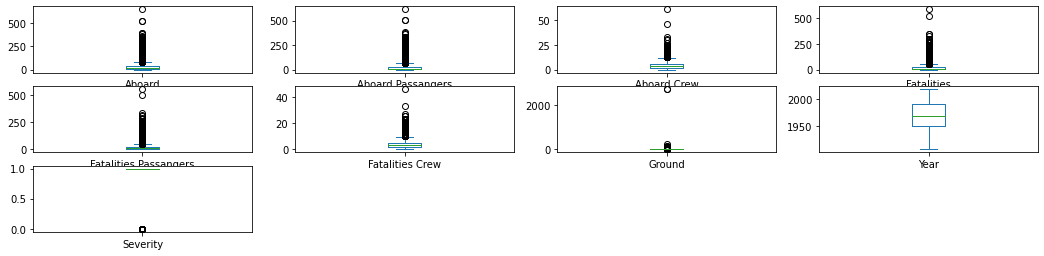

In [4]:
#Check for outliers
df.plot(kind='box', subplots=True, layout=(7,4), sharex=False, sharey=False, figsize=(18,10));
#plt.show()

In [5]:
#Find index position of outlier in df['Ground']
df['Ground'].sort_values().tail()

4327     125.0
2242     125.0
3986     225.0
4329    2750.0
4328    2750.0
Name: Ground, dtype: float64

In [6]:
#Remove outlier based on index position
df.drop([4328, 4329], inplace=True)

In [7]:
#See correlation of features
correl = df.corr()
correl

,Aboard,Aboard Passangers,Aboard Crew,Fatalities,Fatalities Passangers,Fatalities Crew,Ground,Year,Severity
Aboard,1.000000,0.971297,0.577807,0.741535,0.725681,0.301719,-0.003544,0.210497,-0.166999
Aboard Passangers,0.971297,1.000000,0.550595,0.725354,0.750142,0.273759,-0.004913,0.219629,-0.159612
Aboard Crew,0.577807,0.550595,1.000000,0.458933,0.427240,0.768487,0.022520,0.094910,-0.056731
Fatalities,0.741535,0.725354,0.458933,1.000000,0.968019,0.544207,0.004734,0.161562,0.216572
Fatalities Passangers,0.725681,0.750142,0.427240,0.968019,1.000000,0.498369,0.003812,0.170212,0.185709
Fatalities Crew,0.301719,0.273759,0.768487,0.544207,0.498369,1.000000,0.022379,0.043141,0.338555
Ground,-0.003544,-0.004913,0.022520,0.004734,0.003812,0.022379,1.000000,0.036387,-0.021968
Year,0.210497,0.219629,0.094910,0.161562,0.170212,0.043141,0.036387,1.000000,-0.046592
Severity,-0.166999,-0.159612,-0.056731,0.216572,0.185709,0.338555,-0.021968,-0.046592,1.000000


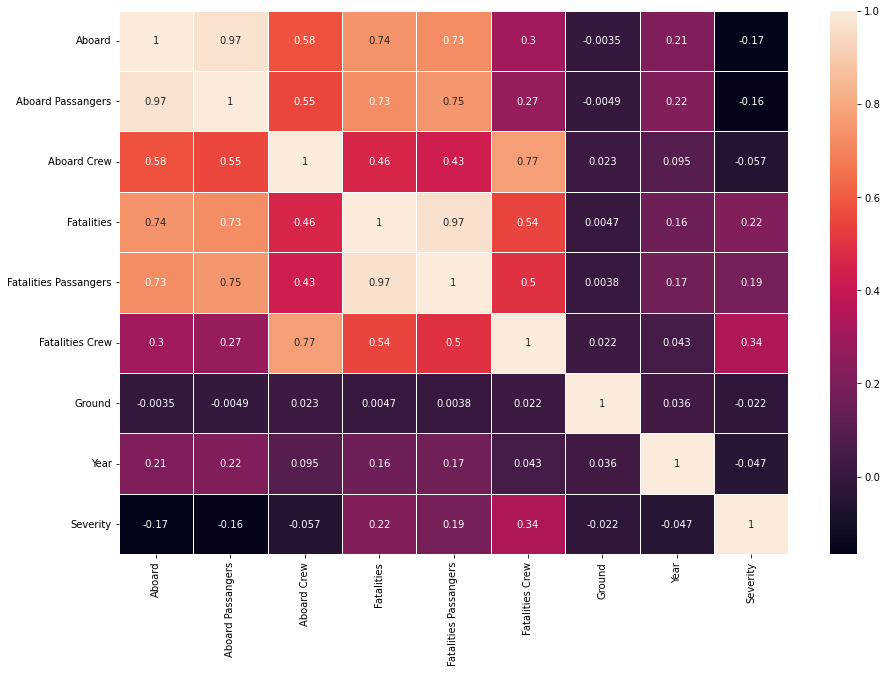

In [8]:
#Visualize the correlation
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(correl, linewidths=1, annot=True, color='r')

VISUALIZATIONS

In [9]:
df.head()

,Aboard,Aboard Passangers,Aboard Crew,Fatalities,Fatalities Passangers,Fatalities Crew,Ground,Year,Severity
0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,1908,0
1,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1909,1
2,5.0,0.0,5.0,5.0,0.0,5.0,0.0,1912,1
3,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1913,1
4,20.0,0.0,1.0,14.0,0.0,1.0,0.0,1913,1


In [10]:
#See highest number of airplane crashes by year
df['Year'].value_counts().head(10)

1946    88
1989    83
1947    82
1948    77
1962    77
1972    77
1951    75
1994    74
1945    74
1970    73
Name: Year, dtype: int64

(array([ 33., 208., 383., 735., 708., 698., 583., 705., 585., 327.]),
 array([1908. , 1919.1, 1930.2, 1941.3, 1952.4, 1963.5, 1974.6, 1985.7,
        1996.8, 2007.9, 2019. ]),
 <BarContainer object of 10 artists>)

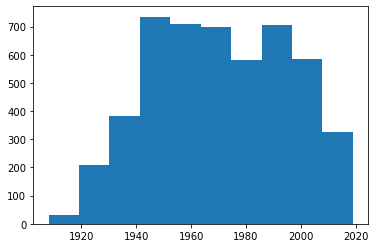

In [11]:
#Histogram showing airplane crashes based on year
plt.hist(df['Year'])

In [12]:
#Actual values of severity. 1 represents positive, 0 represents negative. That is, severe crashes or not severe crashes
df['Severity'].value_counts()

1    4042
0     923
Name: Severity, dtype: int64

<AxesSubplot:xlabel='Severity', ylabel='Relative Frequency'>

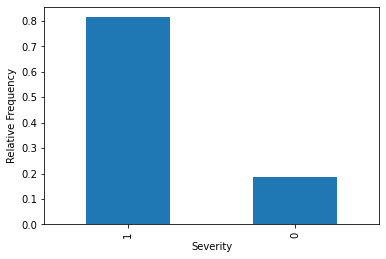

In [13]:
#Relative frequency of severity of airplane crashes
df['Severity'].value_counts(normalize=True).plot(kind='bar', xlabel='Severity', ylabel='Relative Frequency')

Text(0.5, 1.0, 'Aboard vs. Fatalities')

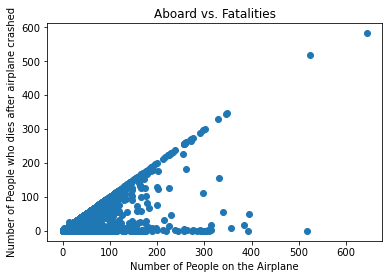

In [14]:
#See relationship between aboard and fatalities
plt.scatter(x=df['Aboard'], y=df['Fatalities'])
plt.xlabel('Number of People on the Airplane')
plt.ylabel('Number of People who dies after airplane crashed')
plt.title('Aboard vs. Fatalities')

<AxesSubplot:xlabel='Severity', ylabel='Aboard'>

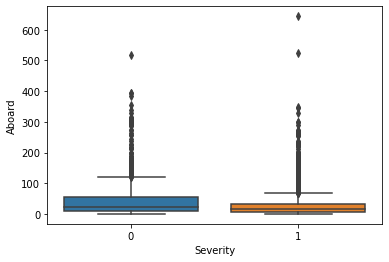

In [15]:
#Visualization between a discontinuous variable and a continuous variable
sns.boxplot(x='Severity', y='Aboard', data=df)

## MODELING
SPLIT

In [16]:
df.head()

,Aboard,Aboard Passangers,Aboard Crew,Fatalities,Fatalities Passangers,Fatalities Crew,Ground,Year,Severity
0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,1908,0
1,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1909,1
2,5.0,0.0,5.0,5.0,0.0,5.0,0.0,1912,1
3,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1913,1
4,20.0,0.0,1.0,14.0,0.0,1.0,0.0,1913,1


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4965 entries, 0 to 4966
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Aboard                 4965 non-null   float64
 1   Aboard Passangers      4965 non-null   float64
 2   Aboard Crew            4965 non-null   float64
 3   Fatalities             4965 non-null   float64
 4   Fatalities Passangers  4965 non-null   float64
 5   Fatalities Crew        4965 non-null   float64
 6   Ground                 4965 non-null   float64
 7   Year                   4965 non-null   int64  
 8   Severity               4965 non-null   int64  
dtypes: float64(7), int64(2)
memory usage: 387.9 KB


In [18]:
#Remove duplicated rows again
df.drop_duplicates(keep='first', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4455 entries, 0 to 4966
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Aboard                 4455 non-null   float64
 1   Aboard Passangers      4455 non-null   float64
 2   Aboard Crew            4455 non-null   float64
 3   Fatalities             4455 non-null   float64
 4   Fatalities Passangers  4455 non-null   float64
 5   Fatalities Crew        4455 non-null   float64
 6   Ground                 4455 non-null   float64
 7   Year                   4455 non-null   int64  
 8   Severity               4455 non-null   int64  
dtypes: float64(7), int64(2)
memory usage: 348.0 KB


In [19]:
#Split: X and y. Target and features
y=df['Severity']
X = df.drop('Severity', axis=1)

In [20]:
#Split: Training and Testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [21]:
#Select classifier models
model = LogisticRegression(C=0.204, solver='liblinear')
#Fit model to data
model.fit(X_train, y_train)

LogisticRegression(C=0.204, solver='liblinear')

In [22]:
#Check model score on training and test sets. This score = accuracy. How much predictions were accurate?
train_score = accuracy_score(y_train, model.predict(X_train))
test_score = model.score(X_test, y_test)
print(train_score)
test_score

0.9974747474747475


0.9988776655443322

In [23]:
#Evaluate
#Confusion matrix gives breakdown of predictions
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[185   1]
 [  0 705]]


Text(33.0, 0.5, 'Predicted label')

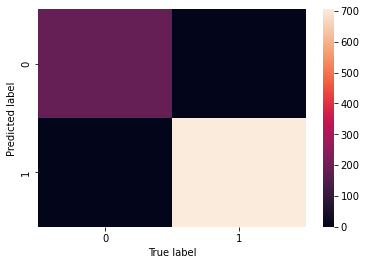

In [24]:
#Visualiza confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred))
plt.xlabel('True label')
plt.ylabel('Predicted label')

In [25]:
#Extract feature names and Importances
features = model.coef_[0]
feature_dict = dict(zip(df.columns, list(features)))
feature_dict

{'Aboard': -1.3655242040124986,
 'Aboard Passangers': -0.03179892969214606,
 'Aboard Crew': -0.37437451645246955,
 'Fatalities': 2.7232489388370356,
 'Fatalities Passangers': 0.040438317017723394,
 'Fatalities Crew': 0.4189758378719251,
 'Ground': -0.021358254696847004,
 'Year': 2.3767794387062656e-05}

<AxesSubplot:title={'center':'Feature Importance'}>

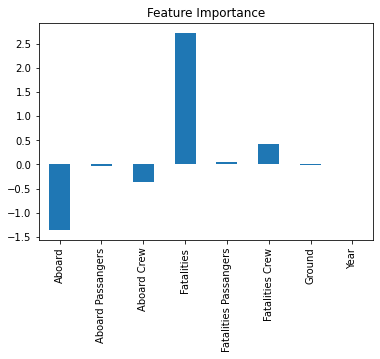

In [26]:
#Visualize Important features
feature_df = pd.DataFrame(feature_dict, index=[0])
feature_df.T.plot.bar(title='Feature Importance', legend=False)

'Aboard' and 'Aboard Crew'
'Fatalities' and 'Fatalities Crew' contributed more to the model performance.
Negative values on y-axis refer to negative correlation.
Positive values on y-axis refer to positive correlation
Fatalities with a value of 2.72, show that as the fatalities increase, the plane crash will be termed severe.